In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_array, check_is_fitted

import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import inspect
import random
import shutil

from datetime import datetime
from dateutil.relativedelta import relativedelta

from scipy import optimize, ndimage
from sklearn import decomposition, cluster, model_selection, metrics
import sklearn

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import utils.dataset_utils as dataset
import utils.train_utils as train

import numpy.polynomial.polynomial as poly

In [2]:
def unit_vector_norm(X):
    return (X.T / np.sqrt((X**2).sum(axis=1))).T

def split_Raman_af(X):
    """
    Removing spikes from the data to extract the autofluorescence.
    This is done by applying smoothing filter to the data and then taking the min of the smoothing filter and original data.
    """
    a = X
    c = 50

    # remove the top of the spikes from data, by using a Gaussian smoothing filter
    for _ in range(5):      
        a[:,c] = X[:,c]
        a[:,-c] = X[:,-c]      
        a1 = ndimage.gaussian_filter(a, (0, 30), mode='nearest')
        a = np.min([a, a1], axis=0)

    # remove the spikes from data, by using a polynominal fit
    for _ in range(5):
        a[:,c] = X[:,c]
        a[:,-c] = X[:,-c]        
        z = poly.polyfit(wavelength[::5], a[:,::5].T, 5)
        a1 = poly.polyval(wavelength, z)
        a = np.min([a, a1], axis=0)
        
    # smooth the curve the data, (to remove remnants of noise in the photoluminescence signal)
    for _ in range(10):           
        a[:,1] = X[:,1]
        a[:,-1] = X[:,-1]         
        a = ndimage.gaussian_filter(a, (0, 10), mode='nearest')

    # make the Raman signal non-negative, (to remove remnants of noise in the Raman signal)
    return (X-a).clip(min=0), a 

def smoothing(X, smooth=5, transition=10, spike_width=7):
    """
    Only remove noise from low noise to signal area's to maintain the intensity of the spikes.
    Noise is removed with a gaussian filter in spectral dimension.
    """
    grad = ndimage.gaussian_filter(X, (0, 1), order=1)
    grad_abs = np.abs(grad)
    grad_abs_sm = ndimage.gaussian_filter(grad_abs, (0, 5))
    mean_grad = np.mean(grad_abs, 1) + 1 / np.std(grad_abs, 1) * 3
    
    spikes = ((grad_abs_sm.T > mean_grad ).astype(float)).T 
    spikes = np.round(ndimage.gaussian_filter(spikes, (0, spike_width)))
    spikes = ndimage.uniform_filter(spikes, (0, transition))
    
    return (1 - spikes) * ndimage.gaussian_filter(X, (0,smooth)) + spikes * X

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [3]:
N_WAVE = 2126

X = np.load("../data/Raman/Alina_art_1_1.npy", 'r')[:,:,2:N_WAVE+2]
Y = np.load("../data/Raman/Alina_art_2_1.npy", 'r')
Z = np.load("../data/Raman/Alina_Art_4_2.npy", 'r')

wavelength = np.load("../data/Raman/wavelength.npy", 'r')

shape_X = X.shape 
shape_Y = Y.shape
shape_Z = Z.shape 

X = copy.copy(X.reshape(-1, X.shape[-1]))
X_smooth = smoothing(X)
ram_X, afl_X = split_Raman_af(X_smooth)

Y = copy.copy(Y.reshape(-1, Y.shape[-1]))
Y_smooth = smoothing(Y)
ram_Y, afl_Y = split_Raman_af(Y_smooth)

Z = copy.copy(Z.reshape(-1, Z.shape[-1]))
Z_smooth = smoothing(Z)
ram_Z, afl_Z = split_Raman_af(Z_smooth)


In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, n_components=10, depth=2, neurons=100, bias=True, **kwargs):
        super().__init__()
        self.encode = nn.Sequential( 
            nn.Dropout3d(0.25),
            nn.Flatten(),
            nn.Linear(N_WAVE, neurons, bias=bias),
            nn.ReLU(True),
            *((nn.Linear(neurons, neurons, bias=bias),
            nn.ReLU(True)) * (depth-1)),
            nn.Linear(neurons, n_components, bias=bias),
            nn.Softmax(1),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(n_components, neurons, bias=bias),
            nn.ReLU(True),
            *((nn.Linear(neurons, neurons, bias=bias),
            nn.ReLU(True)) * (depth-1)),            
            nn.Linear(neurons, N_WAVE, bias=bias),
            View((-1,1,1,1,N_WAVE)),
        )
        
    def forward(self, x):
        return self.decode(self.encode(x))  

In [5]:
def MSE_loss(x, model):
    W = model.encode(x)
    x_ = model.decode(W)

    alpha = 0.8
    rho = 0.8
    
    max_ref_diff = alpha * torch.abs(W).sum(1).mean(0)        
    max_ref_diff += (1 - alpha) * ((W.sum(1))**2).mean(0)
        
    #MSE loss
    MSE = ((x_ - x)**2).sum(4).mean()  
    
    return rho * MSE + (1 - rho) * max_ref_diff

In [6]:
class ReferenceVectorClassifierAE(BaseEstimator):
    def __init__(self, **kwargs):
        self.kwargs = {}
        self.ae_kwargs = {}        
        self.set_params(**kwargs)

        _use_cuda = torch.cuda.is_available() and kwargs['cuda']
        if _use_cuda:
            torch.backends.cudnn.enabled = True
            torch.backends.cudnn.benchmark = True
        self.device = torch.device('cuda' if _use_cuda else 'cpu')        
        
    def fit(self, x, **kwargs):
        self.set_params(**kwargs)
        X = unit_vector_norm(x)
        
        ###################### Autoencoder ################################
        self.model = AutoEncoder(**self.ae_kwargs).to(self.device)
        
        parameters = filter(lambda x: x.requires_grad, self.model.parameters())
        self.optimizer = optim.Adam(parameters)        
        train_loader, test_loader = dataset.load_liver(X, self.kwargs['batch_size'])
        
        for epoch in range(self.kwargs['epochs']):
#             print('-'*50)
#             print('Epoch {:3d}/{:3d}'.format(epoch+1, self.kwargs['epochs']))
            start_time = datetime.now()
            train.train(self.model, self.optimizer, train_loader, self.kwargs['loss_func'], self.kwargs['log_step'], self.device)
            end_time = datetime.now()
            time_diff = relativedelta(end_time, start_time)
#             print('Elapsed time: {}h {}m {}s'.format(time_diff.hours, time_diff.minutes, time_diff.seconds))
            loss = train.test(self.model, test_loader, self.kwargs['loss_func'], self.device)
#             print('Validation| bits: {:2.2f}'.format(loss), flush=True)                     

        self.model.eval()
        with torch.no_grad():
            W = self.model.encode(dataset.load_liver_all(X).to(self.device))
        self.z = W
        W = W.cpu().detach().numpy()
                          
        ###################### reference spectra ################################
        self.reference_spectra_ = unit_vector_norm(W.T @ X)    
        self.ref_org = unit_vector_norm(W.T @ x)
            
        # Return the classifier
        return self
    
    def predict(self, X):
        """
        predict transforms the data into the reference space. Min weight should be 0 or higher then 'min_weight'
        The error is the NMSE, where the MSE is normalised by the signal strength. 
        error.shape = X.shape[0], so for each data point the error is calculated.
        """
        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)
        X = unit_vector_norm(X)
        
        ###################### RCA ################################           
        self.model.eval()
        with torch.no_grad():
            W = self.model.encode(dataset.load_liver_all(X).to(self.device))   
        
        return W.cpu().detach().numpy()
    
    def get_Y(self, X):
        return self.model(dataset.load_liver_all(unit_vector_norm(X)).to(self.device)).squeeze().cpu().detach().numpy()
    
    def get_reference_vectors(self):
        return self.reference_spectra_

    def get_org_reference_vectors(self):
        return self.ref_org    
    
    def get_params(self, deep=False):
        return self.kwargs
    
    def set_params(self, **kwargs):
        self.kwargs.update(kwargs)
        self.ae_kwargs.update({k:v  for k,v in kwargs.items() if k in list(inspect.signature(AutoEncoder).parameters.keys())})     
        return self

In [7]:
def error_map(estimator, X, y=None):
    Y = estimator.get_Y(X)
    return ((Y - X)**2).sum(1)

def score_func(estimator, X, y=None):
    tmp = np.sqrt((X**2).sum(axis=1))
    X = unit_vector_norm(X)
    return (error_map(estimator, X) * tmp).mean()

def print_mean_std(X):
    return f"{X.mean():<12.4e}{X.std():<12.4e}"

def cross_val_X_Y_Z(rvc, X, Y, Z):
    score = []
    for _ in range(10):
        rvc.fit(np.concatenate((X, Y), axis=0))
        score.append(score_func(rvc, Z))
    return np.array(score)

In [8]:
kwargs = {'n_components': 3,
          'n_clusters': 3,
          'batch_size': 32,
          'cuda': True,
          'log_step': 30,
          'loss_func': MSE_loss,
          'epochs': 20,
          'depth': 3,
          'neurons': 532,
          'bias': True
         }

In [9]:
################################# cross_val_score #######################
rvc = ReferenceVectorClassifierAE(**kwargs)
header = f"{'mean':12}{'std':12}"
print(f"{'':25}| {header}")
x = cross_val_X_Y_Z(rvc, ram_Y, ram_Z, ram_X)
y = cross_val_X_Y_Z(rvc, ram_Z, ram_X, ram_Y)
z = cross_val_X_Y_Z(rvc, ram_X, ram_Y, ram_Z)
print(f"cross_val_score Y&Z -> X | {print_mean_std(x)}")
print(f"cross_val_score Z&X -> Y | {print_mean_std(y)}")
print(f"cross_val_score X&Y -> Z | {print_mean_std(z)}")


                         | mean        std         
  2020-07-20 11:43:02|     0/  216| bits: 3.25
  2020-07-20 11:43:02|    30/  216| bits: 0.31
  2020-07-20 11:43:02|    60/  216| bits: 0.28
  2020-07-20 11:43:03|    90/  216| bits: 0.23
  2020-07-20 11:43:03|   120/  216| bits: 0.24
  2020-07-20 11:43:04|   150/  216| bits: 0.24
  2020-07-20 11:43:04|   180/  216| bits: 0.28
  2020-07-20 11:43:04|   210/  216| bits: 0.25
  2020-07-20 11:43:11|     0/  216| bits: 0.28
  2020-07-20 11:43:11|    30/  216| bits: 0.25
  2020-07-20 11:43:12|    60/  216| bits: 0.21
  2020-07-20 11:43:12|    90/  216| bits: 0.22
  2020-07-20 11:43:13|   120/  216| bits: 0.28
  2020-07-20 11:43:13|   150/  216| bits: 0.23
  2020-07-20 11:43:14|   180/  216| bits: 0.27
  2020-07-20 11:43:14|   210/  216| bits: 0.24
  2020-07-20 11:43:21|     0/  216| bits: 0.24
  2020-07-20 11:43:22|    30/  216| bits: 0.23
  2020-07-20 11:43:22|    60/  216| bits: 0.29
  2020-07-20 11:43:22|    90/  216| bits: 0.27
  2020-0

  2020-07-20 11:45:34|   180/  216| bits: 0.23
  2020-07-20 11:45:34|   210/  216| bits: 0.21
  2020-07-20 11:45:38|     0/  216| bits: 0.22
  2020-07-20 11:45:38|    30/  216| bits: 0.25
  2020-07-20 11:45:38|    60/  216| bits: 0.24
  2020-07-20 11:45:39|    90/  216| bits: 0.22
  2020-07-20 11:45:39|   120/  216| bits: 0.25
  2020-07-20 11:45:39|   150/  216| bits: 0.23
  2020-07-20 11:45:40|   180/  216| bits: 0.29
  2020-07-20 11:45:40|   210/  216| bits: 0.25
  2020-07-20 11:45:44|     0/  216| bits: 0.24
  2020-07-20 11:45:44|    30/  216| bits: 0.22
  2020-07-20 11:45:44|    60/  216| bits: 0.22
  2020-07-20 11:45:45|    90/  216| bits: 0.22
  2020-07-20 11:45:45|   120/  216| bits: 0.23
  2020-07-20 11:45:45|   150/  216| bits: 0.26
  2020-07-20 11:45:46|   180/  216| bits: 0.22
  2020-07-20 11:45:46|   210/  216| bits: 0.22
  2020-07-20 11:45:50|     0/  216| bits: 0.22
  2020-07-20 11:45:50|    30/  216| bits: 0.26
  2020-07-20 11:45:51|    60/  216| bits: 0.22
  2020-07-20 

  2020-07-20 11:47:48|   150/  216| bits: 0.21
  2020-07-20 11:47:49|   180/  216| bits: 0.27
  2020-07-20 11:47:49|   210/  216| bits: 0.23
  2020-07-20 11:47:53|     0/  216| bits: 0.26
  2020-07-20 11:47:53|    30/  216| bits: 0.25
  2020-07-20 11:47:53|    60/  216| bits: 0.21
  2020-07-20 11:47:54|    90/  216| bits: 0.22
  2020-07-20 11:47:54|   120/  216| bits: 0.23
  2020-07-20 11:47:54|   150/  216| bits: 0.24
  2020-07-20 11:47:55|   180/  216| bits: 0.25
  2020-07-20 11:47:55|   210/  216| bits: 0.23
  2020-07-20 11:47:59|     0/  216| bits: 0.23
  2020-07-20 11:47:59|    30/  216| bits: 0.23
  2020-07-20 11:47:59|    60/  216| bits: 0.23
  2020-07-20 11:48:00|    90/  216| bits: 0.21
  2020-07-20 11:48:00|   120/  216| bits: 0.25
  2020-07-20 11:48:00|   150/  216| bits: 0.23
  2020-07-20 11:48:01|   180/  216| bits: 0.23
  2020-07-20 11:48:01|   210/  216| bits: 0.28
  2020-07-20 11:48:05|     0/  216| bits: 0.21
  2020-07-20 11:48:05|    30/  216| bits: 0.21
  2020-07-20 

  2020-07-20 11:50:03|   120/  216| bits: 0.23
  2020-07-20 11:50:03|   150/  216| bits: 0.26
  2020-07-20 11:50:03|   180/  216| bits: 0.23
  2020-07-20 11:50:04|   210/  216| bits: 0.21
  2020-07-20 11:50:07|     0/  216| bits: 0.23
  2020-07-20 11:50:08|    30/  216| bits: 0.22
  2020-07-20 11:50:08|    60/  216| bits: 0.25
  2020-07-20 11:50:08|    90/  216| bits: 0.22
  2020-07-20 11:50:09|   120/  216| bits: 0.24
  2020-07-20 11:50:09|   150/  216| bits: 0.24
  2020-07-20 11:50:09|   180/  216| bits: 0.23
  2020-07-20 11:50:09|   210/  216| bits: 0.25
  2020-07-20 11:50:13|     0/  216| bits: 0.24
  2020-07-20 11:50:13|    30/  216| bits: 0.21
  2020-07-20 11:50:14|    60/  216| bits: 0.23
  2020-07-20 11:50:14|    90/  216| bits: 0.26
  2020-07-20 11:50:14|   120/  216| bits: 0.23
  2020-07-20 11:50:15|   150/  216| bits: 0.25
  2020-07-20 11:50:15|   180/  216| bits: 0.22
  2020-07-20 11:50:15|   210/  216| bits: 0.23
  2020-07-20 11:50:19|     0/  216| bits: 0.25
  2020-07-20 

  2020-07-20 11:52:13|    90/  216| bits: 0.23
  2020-07-20 11:52:13|   120/  216| bits: 0.30
  2020-07-20 11:52:13|   150/  216| bits: 0.22
  2020-07-20 11:52:14|   180/  216| bits: 0.24
  2020-07-20 11:52:14|   210/  216| bits: 0.24
  2020-07-20 11:52:18|     0/  216| bits: 0.21
  2020-07-20 11:52:18|    30/  216| bits: 0.21
  2020-07-20 11:52:18|    60/  216| bits: 0.26
  2020-07-20 11:52:18|    90/  216| bits: 0.22
  2020-07-20 11:52:19|   120/  216| bits: 0.24
  2020-07-20 11:52:19|   150/  216| bits: 0.27
  2020-07-20 11:52:19|   180/  216| bits: 0.21
  2020-07-20 11:52:20|   210/  216| bits: 0.22
  2020-07-20 11:52:23|     0/  216| bits: 0.22
  2020-07-20 11:52:24|    30/  216| bits: 0.22
  2020-07-20 11:52:24|    60/  216| bits: 0.23
  2020-07-20 11:52:24|    90/  216| bits: 0.21
  2020-07-20 11:52:25|   120/  216| bits: 0.23
  2020-07-20 11:52:25|   150/  216| bits: 0.21
  2020-07-20 11:52:25|   180/  216| bits: 0.23
  2020-07-20 11:52:26|   210/  216| bits: 0.21
  2020-07-20 

  2020-07-20 11:54:22|    60/  216| bits: 0.23
  2020-07-20 11:54:22|    90/  216| bits: 0.21
  2020-07-20 11:54:22|   120/  216| bits: 0.21
  2020-07-20 11:54:23|   150/  216| bits: 0.26
  2020-07-20 11:54:23|   180/  216| bits: 0.24
  2020-07-20 11:54:23|   210/  216| bits: 0.24
  2020-07-20 11:54:27|     0/  216| bits: 0.23
  2020-07-20 11:54:27|    30/  216| bits: 0.25
  2020-07-20 11:54:28|    60/  216| bits: 0.24
  2020-07-20 11:54:28|    90/  216| bits: 0.22
  2020-07-20 11:54:28|   120/  216| bits: 0.23
  2020-07-20 11:54:29|   150/  216| bits: 0.26
  2020-07-20 11:54:29|   180/  216| bits: 0.21
  2020-07-20 11:54:29|   210/  216| bits: 0.21
  2020-07-20 11:54:33|     0/  216| bits: 0.22
  2020-07-20 11:54:34|    30/  216| bits: 0.21
  2020-07-20 11:54:34|    60/  216| bits: 0.23
  2020-07-20 11:54:34|    90/  216| bits: 0.22
  2020-07-20 11:54:35|   120/  216| bits: 0.21
  2020-07-20 11:54:35|   150/  216| bits: 0.25
  2020-07-20 11:54:35|   180/  216| bits: 0.25
  2020-07-20 

  2020-07-20 11:56:32|    30/  216| bits: 0.22
  2020-07-20 11:56:32|    60/  216| bits: 0.21
  2020-07-20 11:56:33|    90/  216| bits: 0.22
  2020-07-20 11:56:33|   120/  216| bits: 0.21
  2020-07-20 11:56:33|   150/  216| bits: 0.24
  2020-07-20 11:56:34|   180/  216| bits: 0.26
  2020-07-20 11:56:34|   210/  216| bits: 0.24
  2020-07-20 11:56:38|     0/  216| bits: 0.25
  2020-07-20 11:56:38|    30/  216| bits: 0.21
  2020-07-20 11:56:38|    60/  216| bits: 0.23
  2020-07-20 11:56:39|    90/  216| bits: 0.24
  2020-07-20 11:56:39|   120/  216| bits: 0.22
  2020-07-20 11:56:39|   150/  216| bits: 0.22
  2020-07-20 11:56:40|   180/  216| bits: 0.21
  2020-07-20 11:56:40|   210/  216| bits: 0.23
  2020-07-20 11:56:44|     0/  216| bits: 0.24
  2020-07-20 11:56:44|    30/  216| bits: 0.25
  2020-07-20 11:56:44|    60/  216| bits: 0.25
  2020-07-20 11:56:44|    90/  216| bits: 0.22
  2020-07-20 11:56:45|   120/  216| bits: 0.24
  2020-07-20 11:56:45|   150/  216| bits: 0.21
  2020-07-20 

  2020-07-20 11:58:42|     0/  216| bits: 0.21
  2020-07-20 11:58:42|    30/  216| bits: 0.21
  2020-07-20 11:58:42|    60/  216| bits: 0.23
  2020-07-20 11:58:43|    90/  216| bits: 0.23
  2020-07-20 11:58:43|   120/  216| bits: 0.26
  2020-07-20 11:58:43|   150/  216| bits: 0.25
  2020-07-20 11:58:44|   180/  216| bits: 0.27
  2020-07-20 11:58:44|   210/  216| bits: 0.28
  2020-07-20 11:58:48|     0/  216| bits: 0.24
  2020-07-20 11:58:48|    30/  216| bits: 0.23
  2020-07-20 11:58:48|    60/  216| bits: 0.22
  2020-07-20 11:58:49|    90/  216| bits: 0.24
  2020-07-20 11:58:49|   120/  216| bits: 0.25
  2020-07-20 11:58:49|   150/  216| bits: 0.23
  2020-07-20 11:58:50|   180/  216| bits: 0.21
  2020-07-20 11:58:50|   210/  216| bits: 0.22
  2020-07-20 11:58:54|     0/  216| bits: 0.23
  2020-07-20 11:58:54|    30/  216| bits: 0.22
  2020-07-20 11:58:54|    60/  216| bits: 0.26
  2020-07-20 11:58:55|    90/  216| bits: 0.26
  2020-07-20 11:58:55|   120/  216| bits: 0.23
  2020-07-20 

  2020-07-20 12:00:48|   210/  216| bits: 0.22
  2020-07-20 12:00:52|     0/  216| bits: 0.23
  2020-07-20 12:00:52|    30/  216| bits: 0.21
  2020-07-20 12:00:53|    60/  216| bits: 0.22
  2020-07-20 12:00:53|    90/  216| bits: 0.24
  2020-07-20 12:00:53|   120/  216| bits: 0.21
  2020-07-20 12:00:54|   150/  216| bits: 0.23
  2020-07-20 12:00:54|   180/  216| bits: 0.21
  2020-07-20 12:00:54|   210/  216| bits: 0.27
  2020-07-20 12:00:58|     0/  216| bits: 0.24
  2020-07-20 12:00:58|    30/  216| bits: 0.22
  2020-07-20 12:00:59|    60/  216| bits: 0.22
  2020-07-20 12:00:59|    90/  216| bits: 0.21
  2020-07-20 12:00:59|   120/  216| bits: 0.21
  2020-07-20 12:01:00|   150/  216| bits: 0.21
  2020-07-20 12:01:00|   180/  216| bits: 0.22
  2020-07-20 12:01:00|   210/  216| bits: 0.23
  2020-07-20 12:01:04|     0/  216| bits: 0.27
  2020-07-20 12:01:04|    30/  216| bits: 0.23
  2020-07-20 12:01:04|    60/  216| bits: 0.26
  2020-07-20 12:01:05|    90/  216| bits: 0.23
  2020-07-20 

  2020-07-20 12:02:59|   180/  216| bits: 0.21
  2020-07-20 12:02:59|   210/  216| bits: 0.23
  2020-07-20 12:03:03|     0/  216| bits: 0.25
  2020-07-20 12:03:03|    30/  216| bits: 0.22
  2020-07-20 12:03:03|    60/  216| bits: 0.23
  2020-07-20 12:03:04|    90/  216| bits: 0.25
  2020-07-20 12:03:04|   120/  216| bits: 0.22
  2020-07-20 12:03:04|   150/  216| bits: 0.21
  2020-07-20 12:03:05|   180/  216| bits: 0.21
  2020-07-20 12:03:05|   210/  216| bits: 0.22
  2020-07-20 12:03:09|     0/  216| bits: 0.26
  2020-07-20 12:03:09|    30/  216| bits: 0.23
  2020-07-20 12:03:09|    60/  216| bits: 0.25
  2020-07-20 12:03:10|    90/  216| bits: 0.26
  2020-07-20 12:03:10|   120/  216| bits: 0.22
  2020-07-20 12:03:10|   150/  216| bits: 0.23
  2020-07-20 12:03:11|   180/  216| bits: 0.21
  2020-07-20 12:03:11|   210/  216| bits: 0.21
  2020-07-20 12:03:15|     0/  216| bits: 0.23
  2020-07-20 12:03:15|    30/  216| bits: 0.23
  2020-07-20 12:03:15|    60/  216| bits: 0.23
  2020-07-20 

  2020-07-20 12:05:21|    60/  196| bits: 0.25
  2020-07-20 12:05:21|    90/  196| bits: 0.25
  2020-07-20 12:05:22|   120/  196| bits: 0.26
  2020-07-20 12:05:22|   150/  196| bits: 0.26
  2020-07-20 12:05:22|   180/  196| bits: 0.24
  2020-07-20 12:05:26|     0/  196| bits: 0.24
  2020-07-20 12:05:27|    30/  196| bits: 0.27
  2020-07-20 12:05:27|    60/  196| bits: 0.24
  2020-07-20 12:05:27|    90/  196| bits: 0.23
  2020-07-20 12:05:27|   120/  196| bits: 0.25
  2020-07-20 12:05:28|   150/  196| bits: 0.25
  2020-07-20 12:05:28|   180/  196| bits: 0.27
  2020-07-20 12:05:32|     0/  196| bits: 0.26
  2020-07-20 12:05:32|    30/  196| bits: 0.26
  2020-07-20 12:05:33|    60/  196| bits: 0.24
  2020-07-20 12:05:33|    90/  196| bits: 0.22
  2020-07-20 12:05:33|   120/  196| bits: 0.26
  2020-07-20 12:05:33|   150/  196| bits: 0.25
  2020-07-20 12:05:34|   180/  196| bits: 0.25
  2020-07-20 12:05:38|     0/  196| bits: 0.24
  2020-07-20 12:05:38|    30/  196| bits: 0.26
  2020-07-20 

  2020-07-20 12:07:45|    60/  196| bits: 0.23
  2020-07-20 12:07:45|    90/  196| bits: 0.27
  2020-07-20 12:07:45|   120/  196| bits: 0.24
  2020-07-20 12:07:46|   150/  196| bits: 0.25
  2020-07-20 12:07:46|   180/  196| bits: 0.26
  2020-07-20 12:07:50|     0/  196| bits: 0.24
  2020-07-20 12:07:50|    30/  196| bits: 0.28
  2020-07-20 12:07:50|    60/  196| bits: 0.23
  2020-07-20 12:07:51|    90/  196| bits: 0.28
  2020-07-20 12:07:51|   120/  196| bits: 0.29
  2020-07-20 12:07:51|   150/  196| bits: 0.22
  2020-07-20 12:07:52|   180/  196| bits: 0.23
  2020-07-20 12:07:55|     0/  196| bits: 0.23
  2020-07-20 12:07:56|    30/  196| bits: 0.26
  2020-07-20 12:07:56|    60/  196| bits: 0.30
  2020-07-20 12:07:56|    90/  196| bits: 0.23
  2020-07-20 12:07:57|   120/  196| bits: 0.23
  2020-07-20 12:07:57|   150/  196| bits: 0.25
  2020-07-20 12:07:57|   180/  196| bits: 0.24
  2020-07-20 12:08:01|     0/  196| bits: 0.24
  2020-07-20 12:08:01|    30/  196| bits: 0.27
  2020-07-20 

  2020-07-20 12:10:07|    60/  196| bits: 0.24
  2020-07-20 12:10:08|    90/  196| bits: 0.25
  2020-07-20 12:10:08|   120/  196| bits: 0.24
  2020-07-20 12:10:08|   150/  196| bits: 0.23
  2020-07-20 12:10:09|   180/  196| bits: 0.21
  2020-07-20 12:10:12|     0/  196| bits: 0.21
  2020-07-20 12:10:13|    30/  196| bits: 0.25
  2020-07-20 12:10:13|    60/  196| bits: 0.21
  2020-07-20 12:10:13|    90/  196| bits: 0.23
  2020-07-20 12:10:14|   120/  196| bits: 0.26
  2020-07-20 12:10:14|   150/  196| bits: 0.27
  2020-07-20 12:10:14|   180/  196| bits: 0.21
  2020-07-20 12:10:18|     0/  196| bits: 0.30
  2020-07-20 12:10:18|    30/  196| bits: 0.26
  2020-07-20 12:10:19|    60/  196| bits: 0.21
  2020-07-20 12:10:19|    90/  196| bits: 0.23
  2020-07-20 12:10:19|   120/  196| bits: 0.23
  2020-07-20 12:10:20|   150/  196| bits: 0.24
  2020-07-20 12:10:20|   180/  196| bits: 0.23
  2020-07-20 12:10:24|     0/  196| bits: 0.21
  2020-07-20 12:10:24|    30/  196| bits: 0.22
  2020-07-20 

  2020-07-20 12:12:31|    60/  196| bits: 0.21
  2020-07-20 12:12:31|    90/  196| bits: 0.25
  2020-07-20 12:12:31|   120/  196| bits: 0.24
  2020-07-20 12:12:31|   150/  196| bits: 0.21
  2020-07-20 12:12:32|   180/  196| bits: 0.22
  2020-07-20 12:12:36|     0/  196| bits: 0.31
  2020-07-20 12:12:36|    30/  196| bits: 0.22
  2020-07-20 12:12:36|    60/  196| bits: 0.21
  2020-07-20 12:12:37|    90/  196| bits: 0.21
  2020-07-20 12:12:37|   120/  196| bits: 0.24
  2020-07-20 12:12:37|   150/  196| bits: 0.23
  2020-07-20 12:12:37|   180/  196| bits: 0.23
  2020-07-20 12:12:41|     0/  196| bits: 0.34
  2020-07-20 12:12:42|    30/  196| bits: 0.21
  2020-07-20 12:12:42|    60/  196| bits: 0.24
  2020-07-20 12:12:42|    90/  196| bits: 0.24
  2020-07-20 12:12:43|   120/  196| bits: 0.25
  2020-07-20 12:12:43|   150/  196| bits: 0.21
  2020-07-20 12:12:43|   180/  196| bits: 0.28
  2020-07-20 12:12:47|     0/  196| bits: 0.27
  2020-07-20 12:12:47|    30/  196| bits: 0.25
  2020-07-20 

  2020-07-20 12:14:53|    60/  196| bits: 0.22
  2020-07-20 12:14:54|    90/  196| bits: 0.28
  2020-07-20 12:14:54|   120/  196| bits: 0.30
  2020-07-20 12:14:54|   150/  196| bits: 0.24
  2020-07-20 12:14:55|   180/  196| bits: 0.23
  2020-07-20 12:14:58|     0/  196| bits: 0.25
  2020-07-20 12:14:59|    30/  196| bits: 0.27
  2020-07-20 12:14:59|    60/  196| bits: 0.21
  2020-07-20 12:14:59|    90/  196| bits: 0.26
  2020-07-20 12:15:00|   120/  196| bits: 0.26
  2020-07-20 12:15:00|   150/  196| bits: 0.31
  2020-07-20 12:15:00|   180/  196| bits: 0.23
  2020-07-20 12:15:04|     0/  196| bits: 0.23
  2020-07-20 12:15:04|    30/  196| bits: 0.24
  2020-07-20 12:15:05|    60/  196| bits: 0.27
  2020-07-20 12:15:05|    90/  196| bits: 0.22
  2020-07-20 12:15:05|   120/  196| bits: 0.33
  2020-07-20 12:15:06|   150/  196| bits: 0.35
  2020-07-20 12:15:06|   180/  196| bits: 0.22
  2020-07-20 12:15:10|     0/  196| bits: 0.27
  2020-07-20 12:15:10|    30/  196| bits: 0.23
  2020-07-20 

  2020-07-20 12:17:16|    60/  196| bits: 0.25
  2020-07-20 12:17:17|    90/  196| bits: 0.22
  2020-07-20 12:17:17|   120/  196| bits: 0.21
  2020-07-20 12:17:17|   150/  196| bits: 0.24
  2020-07-20 12:17:18|   180/  196| bits: 0.26
  2020-07-20 12:17:21|     0/  196| bits: 0.22
  2020-07-20 12:17:22|    30/  196| bits: 0.21
  2020-07-20 12:17:22|    60/  196| bits: 0.21
  2020-07-20 12:17:22|    90/  196| bits: 0.21
  2020-07-20 12:17:23|   120/  196| bits: 0.21
  2020-07-20 12:17:23|   150/  196| bits: 0.26
  2020-07-20 12:17:23|   180/  196| bits: 0.23
  2020-07-20 12:17:27|     0/  196| bits: 0.23
  2020-07-20 12:17:27|    30/  196| bits: 0.21
  2020-07-20 12:17:28|    60/  196| bits: 0.26
  2020-07-20 12:17:28|    90/  196| bits: 0.26
  2020-07-20 12:17:28|   120/  196| bits: 0.22
  2020-07-20 12:17:29|   150/  196| bits: 0.22
  2020-07-20 12:17:29|   180/  196| bits: 0.24
  2020-07-20 12:17:33|     0/  196| bits: 0.22
  2020-07-20 12:17:33|    30/  196| bits: 0.22
  2020-07-20 

  2020-07-20 12:19:38|    60/  196| bits: 0.25
  2020-07-20 12:19:39|    90/  196| bits: 0.24
  2020-07-20 12:19:39|   120/  196| bits: 0.26
  2020-07-20 12:19:39|   150/  196| bits: 0.27
  2020-07-20 12:19:40|   180/  196| bits: 0.26
  2020-07-20 12:19:43|     0/  196| bits: 0.25
  2020-07-20 12:19:44|    30/  196| bits: 0.24
  2020-07-20 12:19:44|    60/  196| bits: 0.23
  2020-07-20 12:19:44|    90/  196| bits: 0.24
  2020-07-20 12:19:45|   120/  196| bits: 0.26
  2020-07-20 12:19:45|   150/  196| bits: 0.24
  2020-07-20 12:19:46|   180/  196| bits: 0.27
  2020-07-20 12:19:50|     0/  196| bits: 0.22
  2020-07-20 12:19:50|    30/  196| bits: 0.21
  2020-07-20 12:19:50|    60/  196| bits: 0.21
  2020-07-20 12:19:50|    90/  196| bits: 0.24
  2020-07-20 12:19:51|   120/  196| bits: 0.24
  2020-07-20 12:19:51|   150/  196| bits: 0.24
  2020-07-20 12:19:51|   180/  196| bits: 0.24
  2020-07-20 12:19:55|     0/  196| bits: 0.31
  2020-07-20 12:19:56|    30/  196| bits: 0.24
  2020-07-20 

  2020-07-20 12:22:02|    60/  196| bits: 0.27
  2020-07-20 12:22:02|    90/  196| bits: 0.29
  2020-07-20 12:22:03|   120/  196| bits: 0.21
  2020-07-20 12:22:03|   150/  196| bits: 0.25
  2020-07-20 12:22:03|   180/  196| bits: 0.21
  2020-07-20 12:22:07|     0/  196| bits: 0.21
  2020-07-20 12:22:07|    30/  196| bits: 0.21
  2020-07-20 12:22:08|    60/  196| bits: 0.21
  2020-07-20 12:22:08|    90/  196| bits: 0.22
  2020-07-20 12:22:08|   120/  196| bits: 0.21
  2020-07-20 12:22:09|   150/  196| bits: 0.22
  2020-07-20 12:22:09|   180/  196| bits: 0.27
  2020-07-20 12:22:13|     0/  196| bits: 0.21
  2020-07-20 12:22:13|    30/  196| bits: 0.24
  2020-07-20 12:22:13|    60/  196| bits: 0.29
  2020-07-20 12:22:14|    90/  196| bits: 0.23
  2020-07-20 12:22:14|   120/  196| bits: 0.21
  2020-07-20 12:22:14|   150/  196| bits: 0.21
  2020-07-20 12:22:15|   180/  196| bits: 0.23
  2020-07-20 12:22:18|     0/  196| bits: 0.29
  2020-07-20 12:22:19|    30/  196| bits: 0.32
  2020-07-20 

  2020-07-20 12:27:38|    30/   58| bits: 0.23
  2020-07-20 12:27:42|     0/   58| bits: 0.26
  2020-07-20 12:27:42|    30/   58| bits: 0.26
  2020-07-20 12:27:46|     0/   58| bits: 0.28
  2020-07-20 12:27:46|    30/   58| bits: 0.26
  2020-07-20 12:27:50|     0/   58| bits: 0.24
  2020-07-20 12:27:50|    30/   58| bits: 0.26
  2020-07-20 12:27:54|     0/   58| bits: 0.26
  2020-07-20 12:27:55|    30/   58| bits: 0.23
  2020-07-20 12:27:59|     0/   58| bits: 0.28
  2020-07-20 12:27:59|    30/   58| bits: 0.24
  2020-07-20 12:28:03|     0/   58| bits: 3.59
  2020-07-20 12:28:04|    30/   58| bits: 0.39
  2020-07-20 12:28:08|     0/   58| bits: 0.29
  2020-07-20 12:28:08|    30/   58| bits: 0.27
  2020-07-20 12:28:12|     0/   58| bits: 0.29
  2020-07-20 12:28:12|    30/   58| bits: 0.24
  2020-07-20 12:28:16|     0/   58| bits: 0.27
  2020-07-20 12:28:17|    30/   58| bits: 0.25
  2020-07-20 12:28:20|     0/   58| bits: 0.29
  2020-07-20 12:28:21|    30/   58| bits: 0.29
  2020-07-20 

  2020-07-20 12:33:54|     0/   58| bits: 0.28
  2020-07-20 12:33:54|    30/   58| bits: 0.28
  2020-07-20 12:33:58|     0/   58| bits: 0.27
  2020-07-20 12:33:59|    30/   58| bits: 0.31
  2020-07-20 12:34:02|     0/   58| bits: 0.32
  2020-07-20 12:34:03|    30/   58| bits: 0.33
  2020-07-20 12:34:07|     0/   58| bits: 0.25
  2020-07-20 12:34:07|    30/   58| bits: 0.24
  2020-07-20 12:34:11|     0/   58| bits: 0.27
  2020-07-20 12:34:11|    30/   58| bits: 0.27
  2020-07-20 12:34:15|     0/   58| bits: 0.24
  2020-07-20 12:34:15|    30/   58| bits: 0.28
  2020-07-20 12:34:19|     0/   58| bits: 0.27
  2020-07-20 12:34:19|    30/   58| bits: 0.28
  2020-07-20 12:34:23|     0/   58| bits: 0.26
  2020-07-20 12:34:24|    30/   58| bits: 0.31
  2020-07-20 12:34:28|     0/   58| bits: 0.31
  2020-07-20 12:34:28|    30/   58| bits: 0.27
  2020-07-20 12:34:33|     0/   58| bits: 0.27
  2020-07-20 12:34:33|    30/   58| bits: 0.29
  2020-07-20 12:34:37|     0/   58| bits: 0.25
  2020-07-20 

In [10]:
################################# cross_val_score #######################
rvc = ReferenceVectorClassifierAE(**kwargs)
print(f"{'':18}| {header}")
print(f"cross_val_score X | {print_mean_std(model_selection.cross_val_score(rvc, ram_X, None, scoring=score_func))}")
print(f"cross_val_score Y | {print_mean_std(model_selection.cross_val_score(rvc, ram_Y, None, scoring=score_func))}")
print(f"cross_val_score Z | {print_mean_std(model_selection.cross_val_score(rvc, ram_Z, None, scoring=score_func))}")

                  | mean        std         
  2020-07-20 11:04:58|     0/   15| bits: 3.11
  2020-07-20 11:05:02|     0/   15| bits: 0.49
  2020-07-20 11:05:06|     0/   15| bits: 0.42
  2020-07-20 11:05:10|     0/   15| bits: 0.30
  2020-07-20 11:05:13|     0/   15| bits: 0.29
  2020-07-20 11:05:17|     0/   15| bits: 0.29
  2020-07-20 11:05:21|     0/   15| bits: 0.28
  2020-07-20 11:05:25|     0/   15| bits: 0.32
  2020-07-20 11:05:28|     0/   15| bits: 0.31
  2020-07-20 11:05:32|     0/   15| bits: 0.25
  2020-07-20 11:05:36|     0/   15| bits: 0.28
  2020-07-20 11:05:40|     0/   15| bits: 0.28
  2020-07-20 11:05:43|     0/   15| bits: 0.29
  2020-07-20 11:05:47|     0/   15| bits: 0.29
  2020-07-20 11:05:51|     0/   15| bits: 0.26
  2020-07-20 11:05:54|     0/   15| bits: 0.28
  2020-07-20 11:05:58|     0/   15| bits: 0.27
  2020-07-20 11:06:02|     0/   15| bits: 0.28
  2020-07-20 11:06:06|     0/   15| bits: 0.33
  2020-07-20 11:06:09|     0/   15| bits: 0.26
  2020-07-20 11

  2020-07-20 11:13:37|    30/   31| bits: 0.21
  2020-07-20 11:13:40|     0/   31| bits: 0.23
  2020-07-20 11:13:41|    30/   31| bits: 0.25
  2020-07-20 11:13:44|     0/   31| bits: 0.22
  2020-07-20 11:13:45|    30/   31| bits: 0.22
  2020-07-20 11:13:48|     0/   31| bits: 0.23
  2020-07-20 11:13:49|    30/   31| bits: 0.24
  2020-07-20 11:13:52|     0/   31| bits: 3.63
  2020-07-20 11:13:53|    30/   31| bits: 0.32
  2020-07-20 11:13:56|     0/   31| bits: 0.31
  2020-07-20 11:13:56|    30/   31| bits: 0.30
  2020-07-20 11:14:00|     0/   31| bits: 0.33
  2020-07-20 11:14:00|    30/   31| bits: 0.22
  2020-07-20 11:14:04|     0/   31| bits: 0.25
  2020-07-20 11:14:04|    30/   31| bits: 0.25
  2020-07-20 11:14:08|     0/   31| bits: 0.24
  2020-07-20 11:14:08|    30/   31| bits: 0.24
  2020-07-20 11:14:12|     0/   31| bits: 0.25
  2020-07-20 11:14:12|    30/   31| bits: 0.22
  2020-07-20 11:14:16|     0/   31| bits: 0.28
  2020-07-20 11:14:16|    30/   31| bits: 0.26
  2020-07-20 

  2020-07-20 11:18:36|    60/  142| bits: 0.23
  2020-07-20 11:18:36|    90/  142| bits: 0.22
  2020-07-20 11:18:37|   120/  142| bits: 0.23
  2020-07-20 11:18:41|     0/  142| bits: 0.24
  2020-07-20 11:18:41|    30/  142| bits: 0.25
  2020-07-20 11:18:41|    60/  142| bits: 0.21
  2020-07-20 11:18:41|    90/  142| bits: 0.21
  2020-07-20 11:18:42|   120/  142| bits: 0.26
  2020-07-20 11:18:46|     0/  142| bits: 0.23
  2020-07-20 11:18:46|    30/  142| bits: 0.22
  2020-07-20 11:18:46|    60/  142| bits: 0.22
  2020-07-20 11:18:47|    90/  142| bits: 0.21
  2020-07-20 11:18:47|   120/  142| bits: 0.22
  2020-07-20 11:18:51|     0/  142| bits: 0.25
  2020-07-20 11:18:51|    30/  142| bits: 0.23
  2020-07-20 11:18:52|    60/  142| bits: 0.24
  2020-07-20 11:18:52|    90/  142| bits: 0.22
  2020-07-20 11:18:52|   120/  142| bits: 0.23
  2020-07-20 11:18:57|     0/  142| bits: 0.23
  2020-07-20 11:18:57|    30/  142| bits: 0.26
  2020-07-20 11:18:57|    60/  142| bits: 0.26
  2020-07-20 

  2020-07-20 11:21:41|    60/  142| bits: 0.24
  2020-07-20 11:21:42|    90/  142| bits: 0.24
  2020-07-20 11:21:42|   120/  142| bits: 0.22
  2020-07-20 11:21:46|     0/  142| bits: 0.23
  2020-07-20 11:21:46|    30/  142| bits: 0.21
  2020-07-20 11:21:47|    60/  142| bits: 0.26
  2020-07-20 11:21:47|    90/  142| bits: 0.21
  2020-07-20 11:21:47|   120/  142| bits: 0.21
  2020-07-20 11:21:51|     0/  142| bits: 0.21
  2020-07-20 11:21:51|    30/  142| bits: 0.22
  2020-07-20 11:21:52|    60/  142| bits: 0.24
  2020-07-20 11:21:52|    90/  142| bits: 0.22
  2020-07-20 11:21:52|   120/  142| bits: 0.21
  2020-07-20 11:21:56|     0/  142| bits: 0.23
  2020-07-20 11:21:57|    30/  142| bits: 0.27
  2020-07-20 11:21:57|    60/  142| bits: 0.22
  2020-07-20 11:21:57|    90/  142| bits: 0.22
  2020-07-20 11:21:57|   120/  142| bits: 0.21
  2020-07-20 11:22:01|     0/  142| bits: 0.21
  2020-07-20 11:22:02|    30/  142| bits: 0.21
  2020-07-20 11:22:02|    60/  142| bits: 0.31
  2020-07-20 

  2020-07-20 11:24:45|    60/  142| bits: 0.21
  2020-07-20 11:24:45|    90/  142| bits: 0.21
  2020-07-20 11:24:46|   120/  142| bits: 0.21
  2020-07-20 11:24:50|     0/  142| bits: 3.39
  2020-07-20 11:24:51|    30/  142| bits: 0.37
  2020-07-20 11:24:51|    60/  142| bits: 0.22
  2020-07-20 11:24:51|    90/  142| bits: 0.27
  2020-07-20 11:24:52|   120/  142| bits: 0.23
  2020-07-20 11:24:56|     0/  142| bits: 0.25
  2020-07-20 11:24:56|    30/  142| bits: 0.22
  2020-07-20 11:24:56|    60/  142| bits: 0.21
  2020-07-20 11:24:57|    90/  142| bits: 0.23
  2020-07-20 11:24:57|   120/  142| bits: 0.23
  2020-07-20 11:25:01|     0/  142| bits: 0.21
  2020-07-20 11:25:01|    30/  142| bits: 0.21
  2020-07-20 11:25:02|    60/  142| bits: 0.23
  2020-07-20 11:25:02|    90/  142| bits: 0.25
  2020-07-20 11:25:02|   120/  142| bits: 0.24
  2020-07-20 11:25:06|     0/  142| bits: 0.25
  2020-07-20 11:25:07|    30/  142| bits: 0.22
  2020-07-20 11:25:07|    60/  142| bits: 0.26
  2020-07-20 

  2020-07-21 11:56:15|     0/   58| bits: 3.18
  2020-07-21 11:56:15|    30/   58| bits: 0.44
  2020-07-21 11:56:24|     0/   58| bits: 0.28
  2020-07-21 11:56:24|    30/   58| bits: 0.29
  2020-07-21 11:56:29|     0/   58| bits: 0.28
  2020-07-21 11:56:29|    30/   58| bits: 0.29
  2020-07-21 11:56:33|     0/   58| bits: 0.27
  2020-07-21 11:56:34|    30/   58| bits: 0.24
  2020-07-21 11:56:38|     0/   58| bits: 0.28
  2020-07-21 11:56:38|    30/   58| bits: 0.31
  2020-07-21 11:56:42|     0/   58| bits: 0.25
  2020-07-21 11:56:42|    30/   58| bits: 0.26
  2020-07-21 11:56:46|     0/   58| bits: 0.24
  2020-07-21 11:56:47|    30/   58| bits: 0.27
  2020-07-21 11:56:51|     0/   58| bits: 0.26
  2020-07-21 11:56:51|    30/   58| bits: 0.24
  2020-07-21 11:56:55|     0/   58| bits: 0.25
  2020-07-21 11:56:56|    30/   58| bits: 0.26
  2020-07-21 11:57:00|     0/   58| bits: 0.30
  2020-07-21 11:57:01|    30/   58| bits: 0.25
  2020-07-21 11:57:05|     0/   58| bits: 0.25
  2020-07-21 

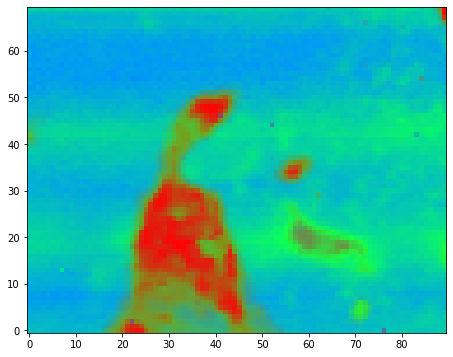

In [12]:
rvc = ReferenceVectorClassifierAE(**kwargs)
rvc.fit(np.concatenate((ram_X, ram_Y), axis=0))
print(score_func(rvc, ram_Z))
RCA_vector = rvc.predict(ram_Z)

RCA_vector = RCA_vector - RCA_vector.min(0)
RCA_vector /= RCA_vector.max(0)

plt.figure(figsize = (20,6))
plt.imshow(RCA_vector.reshape((*shape_Z[:2], 3))[::-1,:,:3])
plt.gca().invert_yaxis()
plt.show()

  2020-07-21 11:57:51|     0/  216| bits: 3.03
  2020-07-21 11:57:51|    30/  216| bits: 0.30
  2020-07-21 11:57:51|    60/  216| bits: 0.24
  2020-07-21 11:57:52|    90/  216| bits: 0.25
  2020-07-21 11:57:52|   120/  216| bits: 0.24
  2020-07-21 11:57:53|   150/  216| bits: 0.24
  2020-07-21 11:57:53|   180/  216| bits: 0.28
  2020-07-21 11:57:53|   210/  216| bits: 0.24
  2020-07-21 11:57:57|     0/  216| bits: 0.24
  2020-07-21 11:57:57|    30/  216| bits: 0.23
  2020-07-21 11:57:58|    60/  216| bits: 0.24
  2020-07-21 11:57:58|    90/  216| bits: 0.22
  2020-07-21 11:57:58|   120/  216| bits: 0.26
  2020-07-21 11:57:59|   150/  216| bits: 0.23
  2020-07-21 11:57:59|   180/  216| bits: 0.28
  2020-07-21 11:58:00|   210/  216| bits: 0.28
  2020-07-21 11:58:04|     0/  216| bits: 0.24
  2020-07-21 11:58:04|    30/  216| bits: 0.24
  2020-07-21 11:58:05|    60/  216| bits: 0.24
  2020-07-21 11:58:05|    90/  216| bits: 0.26
  2020-07-21 11:58:05|   120/  216| bits: 0.23
  2020-07-21 

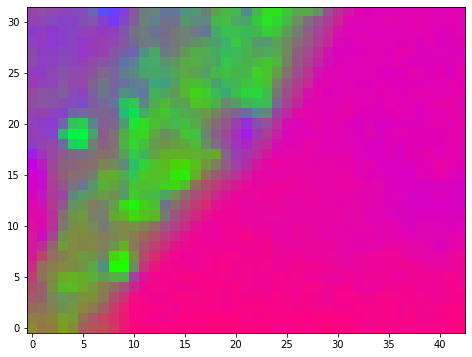

In [13]:
rvc = ReferenceVectorClassifierAE(**kwargs)
rvc.fit(np.concatenate((ram_Z, ram_Y), axis=0))
print(score_func(rvc, ram_Y))
RCA_vector = rvc.predict(ram_Y)

RCA_vector = RCA_vector - RCA_vector.min(0)
RCA_vector /= RCA_vector.max(0)

plt.figure(figsize = (20,6))
plt.imshow(RCA_vector.reshape((*shape_Y[:2], 3))[::-1,:,:3])
plt.gca().invert_yaxis()
plt.show()

  2020-07-21 12:00:00|     0/  216| bits: 3.37
  2020-07-21 12:00:00|    30/  216| bits: 0.32
  2020-07-21 12:00:00|    60/  216| bits: 0.27
  2020-07-21 12:00:01|    90/  216| bits: 0.22
  2020-07-21 12:00:01|   120/  216| bits: 0.24
  2020-07-21 12:00:01|   150/  216| bits: 0.26
  2020-07-21 12:00:02|   180/  216| bits: 0.26
  2020-07-21 12:00:02|   210/  216| bits: 0.22
  2020-07-21 12:00:06|     0/  216| bits: 0.26
  2020-07-21 12:00:06|    30/  216| bits: 0.26
  2020-07-21 12:00:07|    60/  216| bits: 0.23
  2020-07-21 12:00:07|    90/  216| bits: 0.25
  2020-07-21 12:00:07|   120/  216| bits: 0.21
  2020-07-21 12:00:08|   150/  216| bits: 0.25
  2020-07-21 12:00:08|   180/  216| bits: 0.25
  2020-07-21 12:00:08|   210/  216| bits: 0.26
  2020-07-21 12:00:12|     0/  216| bits: 0.22
  2020-07-21 12:00:12|    30/  216| bits: 0.28
  2020-07-21 12:00:13|    60/  216| bits: 0.25
  2020-07-21 12:00:13|    90/  216| bits: 0.26
  2020-07-21 12:00:13|   120/  216| bits: 0.23
  2020-07-21 

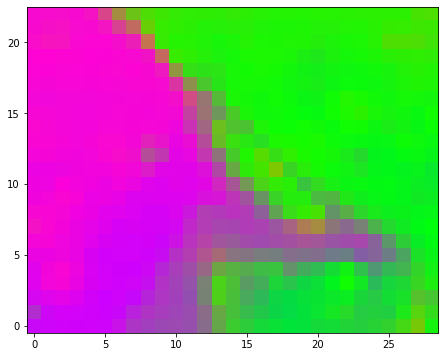

In [14]:
rvc = ReferenceVectorClassifierAE(**kwargs)
rvc.fit(np.concatenate((ram_Z, ram_Y), axis=0))
print(score_func(rvc, ram_X))
RCA_vector = rvc.predict(ram_X)

RCA_vector = RCA_vector - RCA_vector.min(0)
RCA_vector /= RCA_vector.max(0)

plt.figure(figsize = (20,6))
plt.imshow(RCA_vector.reshape((*shape_X[:2], 3))[::-1,:,:3])
plt.gca().invert_yaxis()
plt.show()